
# <span style="color:rgb(213,80,0)">Train Variational Autoencoder (VAE) for image generation and apply to anomaly detection</span>

## Read the dataset

In [1]:
clear;clc;close all;rng(0);
training = true % true: train network,   false: use trained network

training = logical
   0

In [2]:
% define imageDatastore
imds = imageDatastore('train_data_stretched_contrast_normalized\','IncludeSubfolders',true);
Imgsize = [1280 720]; % Image Size after resizing
BlockSize = [640 360]; % Input size of Network
numPatch = 64;
% Resize the image to [1440 2560]
imdsResized = transform(imds, @(x) imresize(x,Imgsize));
imdsTrain = subset(imdsResized.UnderlyingDatastores{1,1}, 1:34); % Separate training data
imdsTest = subset(imdsResized.UnderlyingDatastores{1,1},34:35); % Separate test data
% Use randomPatchExtractionDatastore for image augmentation
dsTrain = randomPatchExtractionDatastore(imdsTrain, imdsTrain, BlockSize,'PatchesPerImage',numPatch);
dsTest = randomPatchExtractionDatastore(imdsTest,imdsTest,BlockSize,'PatchesPerImage',16);
numTrainImages = numel(imdsTrain.Files);

## Create Network

In [3]:
latentDim = 64; % dimension of Latent space
imageSize = [BlockSize 1]; % Input size of Network
% Define an Encoder Network
encoderLG = layerGraph([
    imageInputLayer(imageSize,'Name','input_encoder','Normalization','none')
    convolution2dLayer(3, 8, 'Padding','same', 'Stride', 2, 'Name', 'conv1')
    batchNormalizationLayer('Name', 'bn1')
    leakyReluLayer(0.2,'Name','relu1')
    convolution2dLayer(3, 16, 'Padding','same', 'Stride', 2, 'Name', 'conv2')
    batchNormalizationLayer('Name', 'bn2')
    leakyReluLayer(0.2, 'Name','relu2')
    convolution2dLayer(3, 16, 'Padding','same', 'Stride', 2, 'Name', 'conv3')
    batchNormalizationLayer('Name', 'bn3')
    leakyReluLayer(0.2, 'Name','relu3')
    convolution2dLayer(3, 32, 'Padding','same', 'Stride', 2, 'Name', 'conv4')
    batchNormalizationLayer('Name', 'bn4')
    leakyReluLayer(0.2, 'Name','relu4')
    convolution2dLayer(3, 64, 'Padding','same', 'Stride', 2, 'Name', 'conv5')
    batchNormalizationLayer('Name', 'bn5')
    leakyReluLayer(0.2, 'Name', 'relu5')
    convolution2dLayer(3, 128, 'Padding','same', 'Stride', 2, 'Name', 'conv6')
    batchNormalizationLayer('Name', 'bn6')
    leakyReluLayer(0.2, 'Name', 'relu6')
    fullyConnectedLayer(2*latentDim, 'Name', 'fc_encoder')
    ]);
% Define an Decoder Network
decoderLG = layerGraph([
    imageInputLayer([1 1 latentDim],'Name','i','Normalization','none')
    transposedConv2dLayer(7, 64, 'Cropping', 'same', 'Stride', [4 3], 'Name', 'transpose1')
%     batchNormalizationLayer('Name', 'bn1')
    reluLayer('Name','relu1')
    transposedConv2dLayer(3, 64, 'Cropping', 'same', 'Stride', [4 3], 'Name', 'transpose2')
%     batchNormalizationLayer('Name', 'bn2')
    reluLayer('Name','relu2')
    transposedConv2dLayer(3, 32, 'Cropping', 'same', 'Stride', 2, 'Name', 'transpose3')
%     batchNormalizationLayer('Name', 'bn3')
    reluLayer('Name','relu3')
    transposedConv2dLayer(3, 32, 'Cropping', 'same', 'Stride', 4, 'Name', 'transpose4')
%     batchNormalizationLayer('Name', 'bn4')
    reluLayer('Name','relu4')
    transposedConv2dLayer(3, 16, 'Cropping', 'same', 'Stride', 5, 'Name', 'transpose5')
%     batchNormalizationLayer('Name', 'bn5')
    reluLayer('Name','relu5')
%     transposedConv2dLayer(3, 16, 'Cropping', 'same', 'Stride', 2, 'Name', 'transpose6')
%     batchNormalizationLayer('Name', 'bn6')
%     reluLayer('Name','relu6')
%     transposedConv2dLayer(3, 16, 'Cropping', 'same', 'Stride', 2, 'Name', 'transpose7')
%     reluLayer('Name','relu7')
    transposedConv2dLayer(3, 1, 'Cropping', 'same', 'Name', 'transpose8')
    ]);

## Convert network into dlnetwork type

In [4]:
encoderNet = dlnetwork(encoderLG);
decoderNet = dlnetwork(decoderLG);

## Set training options

In [5]:
executionEnvironment = "auto"; % set execution environment

maxEpochs = 250; % Maximum number of epochs
miniBatchSize = numPatch; % mini Batch Size
lr = 1e-5; % Learning rate
numIterations = floor(numTrainImages/miniBatchSize); % Num of Iteration
iteration = 0;
dsTrain.MiniBatchSize = miniBatchSize;
valFrequency = 10; % Check validation Loss every 10 epochs
minDelta = 20; % Minimum change in loss to be considered improvement
patience = 40; % Number of epochs to wait for improvement
% initialize the average gradient and the average gradient-square decay rates of adam optimizer with empty arrays
avgGradientsEncoder = [];
avgGradientsSquaredEncoder = [];
avgGradientsDecoder = [];
avgGradientsSquaredDecoder = [];

## Train the model

In [6]:
if training
for epoch = 1:maxEpochs
    tic;
    for i = 1:numTrainImages
        iteration = iteration + 1;
        % read the training data and convert to dlarray
        PatchTrain = read(dsTrain);
        XBatch = PatchTrain.InputImage;
        XBatch = cat(4,XBatch{:});
        XBatch = dlarray(single(XBatch)/255, 'SSCB');
        % convert the image data to gpuArray, if the execution Environment is set to GPU
        if (executionEnvironment == "auto" && canUseGPU) ||executionEnvironment == "gpu"
            XBatch = gpuArray(XBatch);
        end
        % Calculate the Elbo loss for training data
        [infGrad, genGrad, trainingElbo] = dlfeval(...
            @modelGradients, encoderNet, decoderNet, XBatch);
        % update parameters of Encoder/Decoder
        [decoderNet.Learnables, avgGradientsDecoder, avgGradientsSquaredDecoder] = ...
            adamupdate(decoderNet.Learnables, ...
                genGrad, avgGradientsDecoder, avgGradientsSquaredDecoder, iteration, lr);
        [encoderNet.Learnables, avgGradientsEncoder, avgGradientsSquaredEncoder] = ...
            adamupdate(encoderNet.Learnables, ...
                infGrad, avgGradientsEncoder, avgGradientsSquaredEncoder, iteration, lr);
    end
    elapsedTime = toc;
    trainingLoss = gather(extractdata(trainingElbo));
    disp("Epoch : "+epoch+" Training ELBO loss = "+ trainingLoss+...
             ". Time taken for epoch = "+ elapsedTime + "s")
    % Reset the datastore object by each epoch
    reset(dsTrain);reset(dsTest);
    % test the model with unknown data
    PatchTest = read(dsTest);
    XTest= PatchTest.InputImage;
    XTest = cat(4, XTest{:});
    XTest = dlarray(single(XTest)/255,'SSCB');
    % Predict the output
    [zVal, zMeanVal, zLogvarVal] = sampling(encoderNet, XTest);
    xPredVal = sigmoid(forward(decoderNet, zVal));
    % Caluculate the Elbo loss
    elboVal = ELBOloss(XTest, xPredVal, zMeanVal, zLogvarVal);
    valLoss = gather(extractdata(elboVal));
    % Initialize variables for early stopping
    bestValLoss = inf;
    wait = 0;
    % check the validation loss periodically and display the results
    if mod(epoch, valFrequency) == 0
        if valLoss < bestValLoss - minDelta
            bestValLoss = valLoss;
            wait = 0; % Reset the patience counter
            disp("Epoch : "+epoch+" Test ELBO loss = "+ valLoss +... % gather: return an array in the local workspace with the data transfered from the gpu
             ". Time taken for epoch = "+ elapsedTime + "s")
        else
            wait = wait + 10;
            if wait >= patience
                disp("Early stopping at epoch "+epoch);
                break
            end
        end
    end
    % show the results

    xPredout = uint8(gather(extractdata(xPredVal))*255);
    subplot(1,2,1);imshow(PatchTest.InputImage{1});
    subplot(1,2,2);imshow(xPredout(:,:,:,1));shg
end
    save(["net.mat"],'decoderNet','encoderNet'); % save the data
else
    load net_240104.mat
end


##  Evaluate the model with images including foreign material



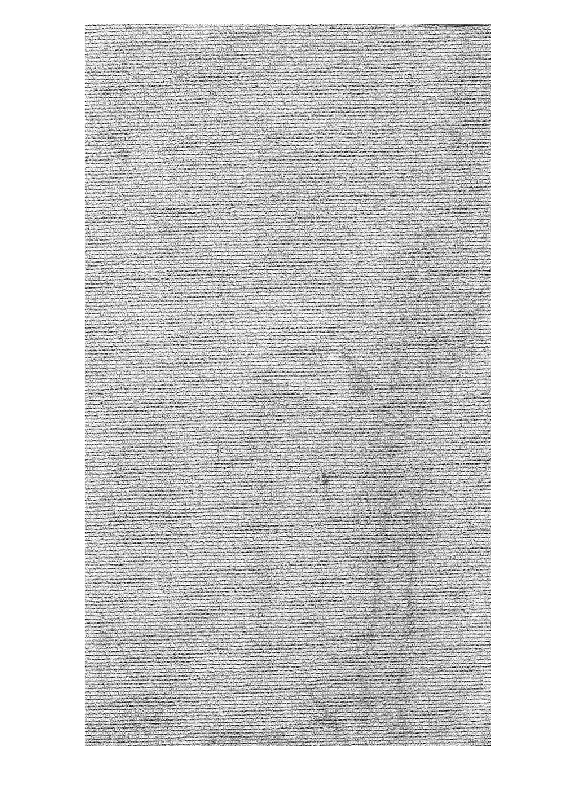


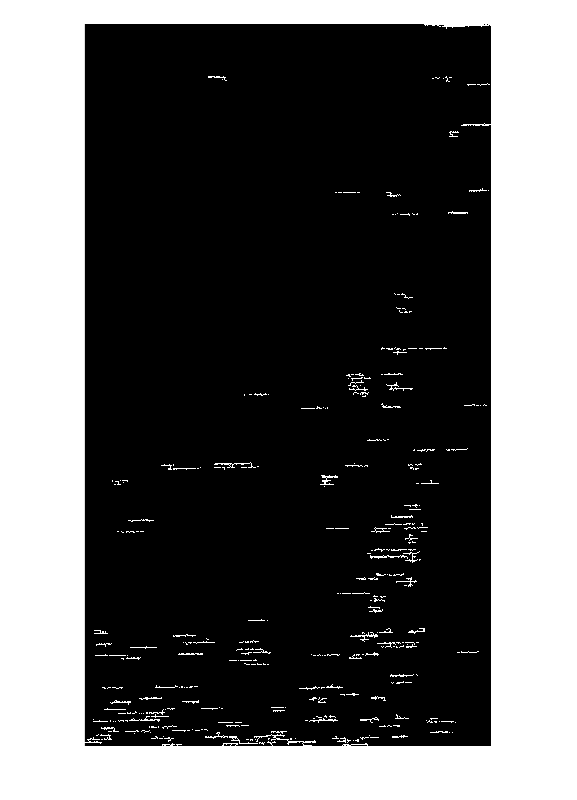

In [7]:
rng(0);
% Define image dataset for evaluation
imdsVal = imageDatastore('test_data_stretched_contrast_normalized\','IncludeSubfolders',true,'LabelSource','foldernames');
imdsValResized = transform(imdsVal, @(x) imresize(x,Imgsize));
imdsVal = imdsValResized.UnderlyingDatastores{1,1};
% set some variables
I_All = uint8(zeros(Imgsize(1),Imgsize(2),3,numel(imdsVal.Files))); % change needed if the number of channels is changed
BW = logical(zeros(Imgsize(1),Imgsize(2),1,numel(imdsVal.Files)));
Predicted_All = uint8(zeros(Imgsize(1),Imgsize(2),3,numel(imdsVal.Files))); % change needed if the number of channels is changed
I_big =uint8(zeros(Imgsize(1),Imgsize(2),3));
Predicted_big =uint8(zeros(1280, 720,3));

for nn=1:numel(imdsVal.Files)
    tic;
    I_big = read(imdsValResized); % Read data from imdsValResized, not imdsVal
    % Process in blocks for large images
    fun = @(block_struct) mypredict(encoderNet, decoderNet,block_struct);
    Predicted_big = gather(blockproc(I_big,BlockSize,fun));
    Predicted_big = uint8(Predicted_big*255);
    % get the difference between the inference result and the original image
    I_big_rgb = cat(3,I_big, I_big, I_big);
    Predicted_big_rgb = cat(3,Predicted_big, Predicted_big, Predicted_big);
    sum_temp = lab2rgb(( rgb2lab(I_big_rgb)+ rgb2lab(Predicted_big_rgb)));
    % sum_temp = (I_big)+ (Predicted_big);
    % Apply image processing algorithm to extract anomaly area
    BW_mask = Maskedge(Predicted_big_rgb);
    % BW_mask = Maskedge(Predicted_big);
    BW_temp = createMask(sum_temp);
    % BW_temp= createMask(subt_temp);
    BW_temp = BW_temp & BW_mask;
    BW_temp = imfill(BW_temp, 'holes');
    BW_temp = bwareaopen(BW_temp,70,18);

    % Concatenate images and results

    I_All(:,:,:,nn) = I_big_rgb;
    % I_All(:,:,:,nn) = I_big;
    Predicted_All(:,:,:,nn) = Predicted_big_rgb;
    % Predicted_All(:,:,:,nn) = Predicted_big;
    BW(:,:,:,nn) = BW_temp;
    % Show the original image and inference image
    figure(figure);
    % subplot(1,3,1); imhist(I_big);
    % subplot(1,3,2); imhist(Predicted_big);
    % imshow(I_big);
    %subplot(1,3,1);
    imshow(I_big_rgb);
    %subplot(1,3,2);imshow(Predicted_big_rgb);
    % subplot(1,3,3); imshow(sum_temp);
    figure
    imshow(BW_temp);
    % subplot(1,2,2);imshow(BW_temp);
    shg
    inference_time = toc;
end

In [8]:
disp("The inference time per image is "+ inference_time +"s");

The inference time per image is 0.56978s


##  Show the segment resultation



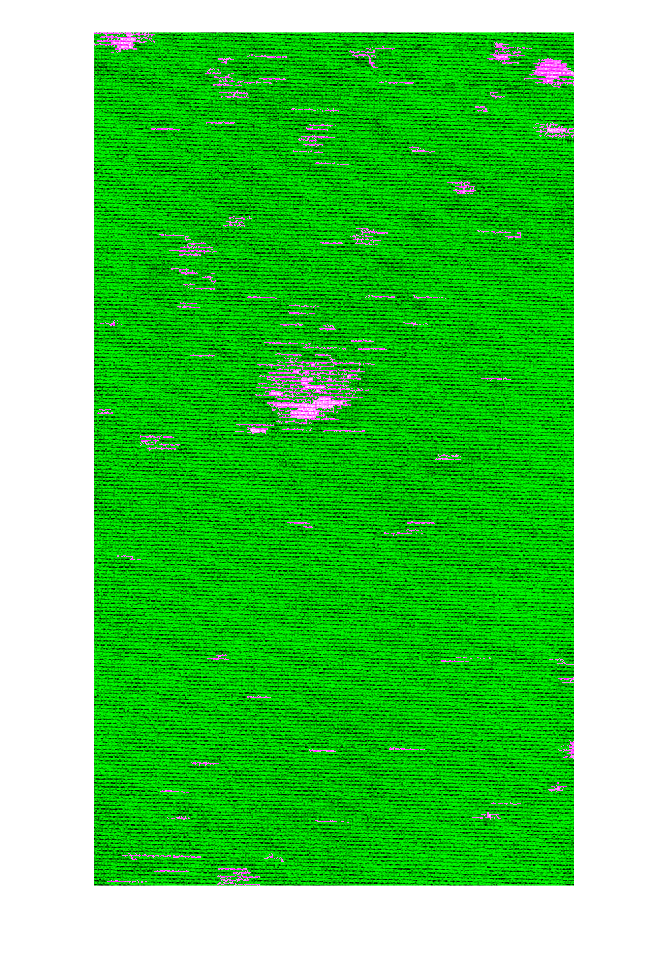

Index exceeds the number of array elements. Index must not exceed 5.

In [9]:
Color = {'r','r','r','r','b'};
% f1 = figure;
f2 = figure;

for k = 6
    % show the result
    % figure(f1), plot(k), imshowpair(uint8(I_All(:,:,:,k)),BW(:,:,k),'montage');shg
    % title(imdsVal.Labels(k),'FontSize',10,'Color', Color{k});
    figure(f2),plot(k), imshowpair(uint8(I_All(:,:,:,k)),BW(:,:,k));shg
    title(imdsVal.Labels(k),'FontSize',10,'Color', Color{k});
end


## Helper function

The `modelGradients` function takes the encoder and decoder `dlnetwork` objects and a mini\-batch of input data `X`, and returns the gradients of the loss with respect to the learnable parameters in the networks. The function performs three operations:

1.  Obtain the encodings by calling the `sampling` function on the mini\-batch of images that passes through the encoder network.
2. Obtain the loss by passing the encodings through the decoder network and calling the `ELBOloss` function.
3. Compute the gradients of the loss with respect to the learnable paramaters of both networks by calling the `dlgradient` function.

In [10]:
function [infGrad, genGrad, trainingLoss] = modelGradients(encoderNet, decoderNet, x)
[z, zMean, zLogvar] = sampling(encoderNet, x);
xPred = sigmoid(forward(decoderNet, z));
trainingLoss = ELBOloss(x, xPred, zMean, zLogvar);
[genGrad, infGrad] = dlgradient(trainingLoss, decoderNet.Learnables, ...
    encoderNet.Learnables);
end

%% Sampling Function
% The sampling function obtains encodings from input images. Initially, it passes a mini-batch of images
% through the encoder network and splits the output of size (2*latentDim)*miniBatchSize into a matrix of
% means and a matrix of variances, each of size latentDim*batchSize. Then, it uses these matrices to implement
% the reparametrization trick and to compute the encoding. Finally, it converts this encoding to a dlarray object
% in SSCB format.
function [zSampled, zMean, zLogvar] = sampling(encoderNet, x)
compressed = forward(encoderNet, x);
d = size(compressed,1)/2;
zMean = compressed(1:d,:);
zLogvar = compressed(1+d:end,:);

sz = size(zMean);
epsilon = randn(sz);
sigma = exp(.5 * zLogvar);
z = epsilon .* sigma + zMean;
z = reshape(z, [1,1,sz]);
zSampled = dlarray(z, 'SSCB');
end
% Loss Function
% The ELBOloss function takes the encodings of the means and the variances returned by the sampling function,
% and uses them to compute the ELBO loss.
function elbo = ELBOloss(x, xPred, zMean, zLogvar)
squares = 0.5*(xPred-x).^2;
reconstructionLoss  = sum(squares, [1,2,3]);
KL = -.5 * sum(1 + zLogvar - zMean.^2 - exp(2*zLogvar), 1);
elbo = mean(reconstructionLoss + KL);
end
% predict function
function xPred = mypredict(encoderNet, decoderNet, block_struct)
    XEval = dlarray(single(block_struct.data)/255,'SSC');
    [z, ~, ~] = sampling(encoderNet, XEval);
    xPred = sigmoid(forward(decoderNet, z));
    xPred = extractdata(xPred);
end

% Functions for postprocessing
% Function to make a mask around the pattern
% function BW = Maskedge(gray)
% I = gray;
% % Define thresholds for grayscale intensity
% intensityMin = 0;  % Define the minimum intensity
% intensityMax = 100;  % Define the maximum intensity
%
% % create a mask based on intensity thresholds
% sliderBW = (I >= intensityMin) & (I <= intensityMax);
% BW1 = sliderBW;
%
% % apply morphological processing
% % BW1 = imfill(BW1, 'holes'); % to ensure that the regions are enclosed
% BW_L = imdilate(BW1, strel('disk', 15));
% BW_S = imerode(BW1, strel('disk', 15));
% BW = ~BW_L;
% end
%
% % the function to extract anomaly area
% function BW = createMask(gray)
% I = gray;
%
% % Define thresholds for grayscale intensity
% intensityMin = 0;  % Define the minimum intensity
% intensityMax = 100;  % Define the maximum intensity
%
% % create a mask based on intensity thresholds
% sliderBW = (I >= intensityMin) & (I <= intensityMax);
% BW = sliderBW;
% end

function BW = Maskedge(RGB)
I = rgb2hsv(RGB);
channel1Min = 0.3;
channel1Max = 0.5;
channel2Min = 0.3;
channel2Max = 0.5;
channel3Min = 0.4;
channel3Max = 0.88;
sliderBW = (I(:,:,1) >= channel1Min ) & (I(:,:,1) <= channel1Max) & ...
    (I(:,:,2) >= channel2Min ) & (I(:,:,2) <= channel2Max) & ...
    (I(:,:,3) >= channel3Min ) & (I(:,:,3) <= channel3Max);
BW1 = sliderBW;

BW1 = imfill(BW1,'holes');
BW_L = imdilate(BW1,strel('disk',2,4));
BW_S = imerode(BW1,strel('disk',10,4));
BW = ~BW_L;
end

function BW = createMask(RGB)
RGB = mat2gray(RGB);
I = rgb2hsv(RGB);
channel1Min = 0.000;
channel1Max = 1.000;

channel2Min = 0.000;
channel2Max = 1.000;

channel3Min = 0.0;
channel3Max = 0.55;
sliderBW = ( (I(:,:,1) >= channel1Min) | (I(:,:,1) <= channel1Max) ) & ...
    (I(:,:,2) >= channel2Min ) & (I(:,:,2) <= channel2Max) & ...
    (I(:,:,3) >= channel3Min ) & (I(:,:,3) <= channel3Max);
BW = sliderBW;
end